In [17]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer

# Set seeds for reproducibility
seed = 123


In [4]:
# load full training set
df = pd.read_pickle(r"train_enc.pkl")

In [5]:
# Separate labels and target
X, y =  df.drop(columns="left", axis = 1), df["left"]
# Create train and validation 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=seed)

In [6]:
# Get variable names
bi_vars = [col for col in X.columns if X[col].nunique() == 2]
num_vars = [col for col in X.columns if (X[col].dtype in ["int8", "float32"]) & (col not in bi_vars)]
cat_vars = [col for col in X.columns if (col not in num_vars) & (col not in bi_vars)]

In [19]:
# Preprocessing recipe
preprocess = ColumnTransformer(
    transformers=[
        ("scaler", MinMaxScaler(), num_vars),
        ("ohe", OneHotEncoder(), cat_vars)
    ], remainder = 'passthrough'
)

In [20]:
# K-folds
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# Define metric
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)  

metric = make_scorer(f2_measure)

## Test Models

>DM 0.673 (0.001)
>LGB 0.727 (0.028)
>CB 0.728 (0.026)
>XGB 0.724 (0.027)


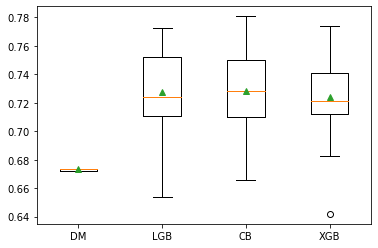

In [21]:
### Especify models ###
# LightGBM
lgbm_model = LGBMClassifier(random_seed=seed)
# Catboost
cb_model = CatBoostClassifier(random_seed=seed)
# XGBoost 
xgb_model = XGBClassifier(random_state=seed)

def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)  

metric = make_scorer(f2_measure)
# Evaluate a model
def evaluate_model(X, y, model):
    # Define the model evaluation metric
    metric = make_scorer(f2_measure)
    # Evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores
    
# Define models to test
def get_models():
    models, names = list(), list()
    # DUMMY
    models.append(DummyClassifier(strategy='constant', constant=1, random_state=seed))
    names.append('DM')
    # LGB
    models.append(lgbm_model)
    names.append('LGB')
    # CB
    models.append(cb_model)
    names.append('CB')
    # XGB
    models.append(xgb_model)
    names.append('XGB')
    return models, names

# Define models
models, names = get_models()
results = list()
# Evaluate each model
for i in range(len(models)):
    # Wrap the model in a pipeline
    base_pipeline = Pipeline(steps=[
        ('recipe',preprocess),
        ('m',models[i])
    ])
    # Evaluate the model and store results
    scores = evaluate_model(X, y, base_pipeline) # <-- using training set for CV
    results.append(scores)
    # Summarize and store
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
    
# Plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()